## A model of variants competition to estimate transmissibility advantage of invading variants

In [1]:
import numpy as np
import pymc as pm
#import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
from scipy.stats import gamma

NOTES: 
T = number of weeks  
Tf = number of weeks to fit with screening data cases and % p  
p0 = initial % of omicron voc per region  
M = number of regions  
rh = growth rate delta type  
rv = gr omicron voc  
Rh = R0 delta type  
Rv = R0 omicron voc  
multilevel model with random intercept: each region is allowed to have an initial p0

## Logistic growth models

<div class="alert alert-info" style="font-size:120%">

**REFERENCES:**   
Fraser et al., Pandemic Potential of a Strain of Influenza A (H1N1): Early Findings. Science 324, 1557-1561 (2009)  
https://www.science.org/doi/10.1126/science.1176062#abstract

* Work on H1N1 from 2009
* Estimate transmissibility advantage of new strain wrt past influenza type
 
Gaymard et al., "Early assessment of diffusion and possible expansion of SARS-CoV-2 Lineage 20I/501Y. V1 (B. 1.1. 7, variant of concern 202012/01) in France, January to March 2021." Eurosurveillance 26.9 (2021)  
https://www.eurosurveillance.org/content/10.2807/1560-7917.ES.2021.26.9.2100133


* Work on Covid-19
* Covid-19 Alpha variant wrt historic strain


Both use logistic growth models of variants competition
</div>

### What is transmissibility advantage?  

Transmissibility, typically encoded by $\beta$ in compartmental models, is a critical parameter for the modelled outbreak. 
This directly determines the reproduction number $R_0$ of the disease in our model. 
$R_0$ denotes the number of secondary infections that an infected individual will produce during their illness period.  

Here we do not simulate transmission at population level, we won't simulate the transmission across individuals passing through different disease states. We'll use the relationship between $R_0$, the growth rate of cases and generation time.

### Generation time, shape, rate and scale

Generation time is one of the most important epidemiological parameters for infectious disease. It encodes the time between the infector's infection and the infectee's infection.
Being a non-observable quantity, it is usually proxied by the $\textit{serial interval}$ , encoding the time between infector's and the infectee's onsets of symptoms, which is directly observable.  

The generation time typically follows a Gamma function with parameters a and b, $\Gamma(a,b)$ where a is the shape and b is the rate parameter.   
Shape $a =\mu^2/ \sigma^2$ and rate $b = \mu/ \sigma^2$, where $\mu$ and $\sigma$ are the mean and standard deviation of the distribution respectively.  
Most functions in statistics packages use a different parameterization $\Gamma(\alpha,\beta)$, with $\alpha = a$ and $\beta = 1/b$  
see (https://medium.com/data-bistrot/gamma-distribution-with-python-f84f671a8b97)  
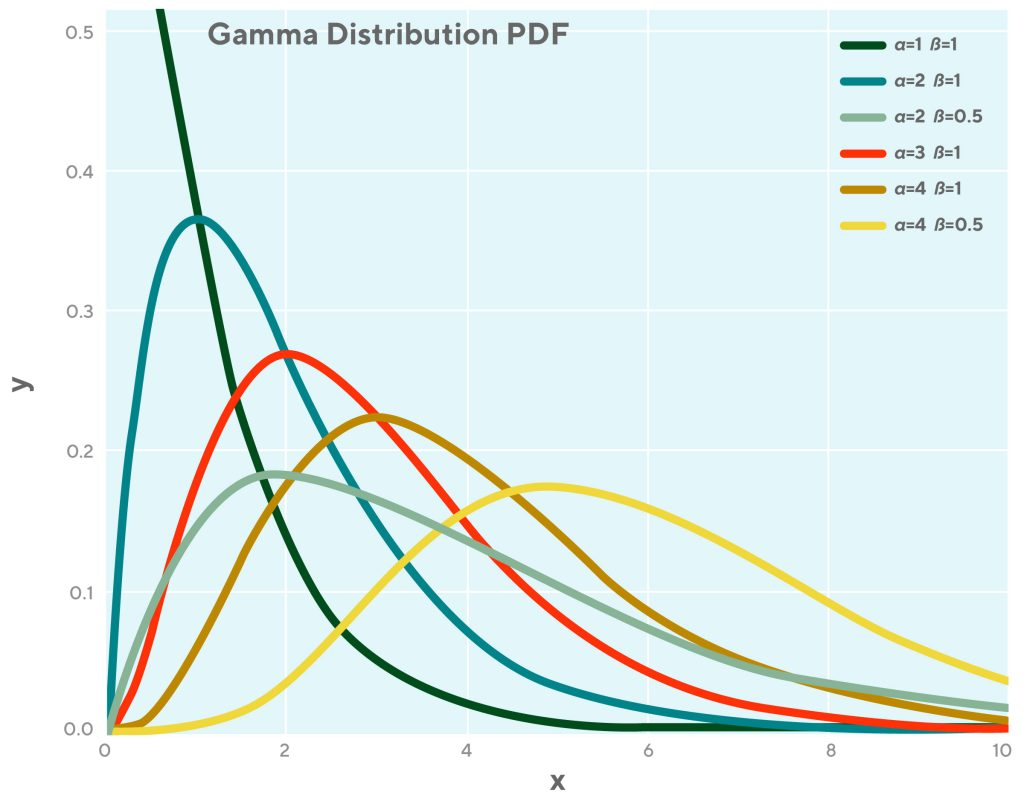

scipy command `gamma.rvs` generates random numbers from a gamma distribution with a custom shape (a) and scale ($\beta$)

Text(0.5, 0, 'days')

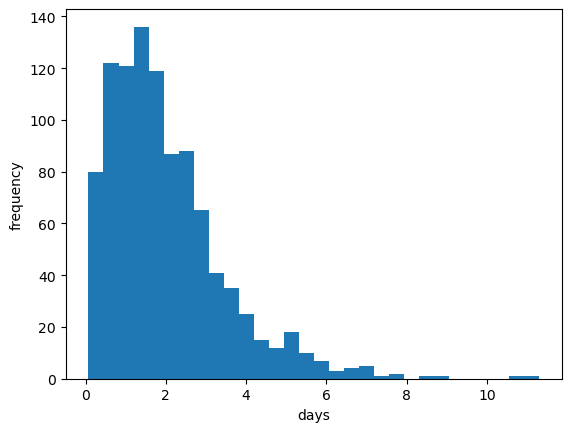

In [2]:
a=2
beta=1
synthetic_gt = gamma.rvs(a=a, scale=beta, size=1000)
plt.hist(synthetic_gt,bins=30);
plt.ylabel('frequency')
plt.xlabel('days')


<div class="alert alert-success">

**EXERCISE 1: Model the generation time distribution**

From the literature, we know the Delta variant generation time parameters, see https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(22)00001-9/fulltext

mean = 4.7 days  
standard deviation = 3.3 days

* Draw the generation time distribution with a gamma function informed with these parameters.
* Calculate the mean from the synthetic sample extracted.
* Calculate the standard deviation from the synthetic sample extracted.
    
<details><summary>Hints</summary>

* Rembember that $a =\mu^2/ \sigma^2$ and $b = \mu/ \sigma^2$
* gamma.rvs uses the $\alpha$ and $\beta$ parameterization, with scale $\beta$ = 1/b

</details>

</div>

In [3]:
gt_mn = 4.7 # mean in days
gt_std = 3.3 # standard deviation
a = (gt_mn/gt_std)**2
b = gt_mn/gt_std**2
beta = 1/b

(4.67001772748359, 3.2083732076903573)

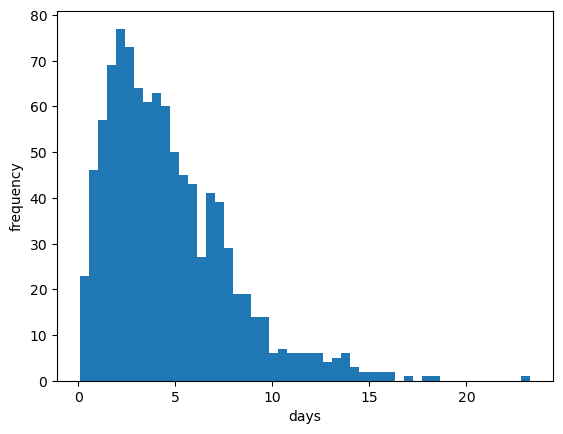

In [4]:
synthetic_gt = gamma.rvs(a=a, scale=1/b, size=1000)
plt.hist(synthetic_gt,bins=50);
plt.ylabel('frequency')
plt.xlabel('days')
np.mean(synthetic_gt), np.std(synthetic_gt)


If $R_0$ sets the reproduction capacity of the virus, defining how many secondary infections an infected host can make, generation time sets the speed of diffusion along the chain of transmission.

### Growth rate

A growth rate of of 1.01 or 1% means that the number of new infections is growing by 1% every day.  
It is fitted with an exponential growth curve.


The variant reproductive number R can be written in function of the growth rate $r_v$ as
$$ \Large R_v = ( 1 + \frac{r_v}{b})^a $$ 
with a and b being shape and rate of the generation time distribution!

We can invert the relation to inform the growth rate $r_h$ of the dominant variant from its $R_0$


In [5]:
Rh_true = 2.0 

gt_mn = 4.7 # mean in days
gt_std = 3.3 # standard deviation
a = (gt_mn/gt_std)**2
b = gt_mn/gt_std**2
beta = 1/b

rh_true = (Rh_true**(1/a) - 1) * b 
print('new cases of dominant strain grow by '+str(round(rh_true*100,2))+' percent every day (in a naive population)')


new cases of dominant strain grow by 17.58 percent every day (in a naive population)



<div class="alert alert-success">

**EXERCISE 2: Estimate growth rate from $R_0$**

Assume a new disease with $R_0 = 1.38$
and a generation time with mean = 3.4 days and standard deviation = 2.2 days

* Compute the growth rate of the disease for a naive population
    
<details><summary>Hints</summary>

* use the relation $ R_v = ( 1 + \frac{r_v}{b})^a $

</details>

</div>

In [6]:
Rh_true = 1.38 

gt_mn = 3.4 # mean in days
gt_std = 2.2 # standard deviation
a = (gt_mn/gt_std)**2
b = gt_mn/gt_std**2
beta = 1/b

rh_true = (Rh_true**(1/a) - 1) * b 
print('new cases of dominant strain grow by '+str(round(rh_true*100,2))+' percent every day (in a naive population)')

new cases of dominant strain grow by 10.14 percent every day (in a naive population)


Now, when a new variant invades the dominant, the host population is not naive anymore, hence we should rely on estimates of the $\textit{Effective Reproductive Number}$, which can be estimated from total case counts using EpiEstim (https://cran.r-project.org/web/packages/EpiEstim/index.html)  
Here, for simplicity we will use $R_0$ with the approximation of naive population, hence we'll refer to $R$ as $R_0$.

During Covid-19 we saw dominant variants alternating one after the other.   
This happened recurrent patterns of invasion in time denoted by the growing fraction of cases from the invading strain wrt to the dominant one.  
In a situation of variants take-over, we can write the relationship between the reproduction number of the dominant and invading variants as:  
$$ \Large  R_v = ( 1 + \alpha) R_h $$  
with $\alpha$ being the transmissibility advantage we want to estimate.  


### What data do we need?

Case counts and prevalence estimates for both the dominant and the invading variant.   
The GISAID project runs as a global platform where genomic data laboratories can upload genomic sequences  (https://gisaid.org/)    
Projects NextStrain take care of aggregating and visualizing the variants behavior in time (https://nextstrain.org/)  

The ECDC (European Center for Disease Control) collected variants prevalence records for the whole pandemic period in all the EU countries (https://www.ecdc.europa.eu/en/publications-data/data-virus-variants-covid-19-eueea)  

Read the data and drop nans

In [170]:
data = pd.read_csv('../data/covid_gisaid.csv')
data = data.dropna()

we can use pandas conditional formatting on `year_week` to select only data in a specific time window 

In [160]:
data = data[(data.year_week>'2021-01')&(data.year_week<='2022-12')]

* remove variants classified as "unknown"   
* focus on Italy
* filter out data coming from other sources than GISAID (e.g. TESSy)
* filter out columns we don't need

In [161]:
data = data[data.variant!='UNK']
data = data[(data.country == 'Italy') & (data.source=='GISAID')]
data = data[['country','year_week','variant', 'number_sequenced', 'number_detections_variant', 'percent_variant']]


now we can create a new dataframe with two indexes
* one on year-week
* one on variant
and see the percentage of sequences of each variant in that week for that country, `percent_variant`


In [162]:
dataf = data.groupby(['year_week', 'variant'])['percent_variant'].sum()
dataf.head()

year_week  variant        
2021-02    B.1.1.529           0.0
           B.1.1.7            12.4
           B.1.351             0.0
           B.1.427/B.1.429     0.1
           B.1.525             0.0
Name: percent_variant, dtype: float64

finally we use the `reset_index` command to recover the tabular view  
the multi-index dataframe is harder to handle than a plain dataframe

In [163]:
dataf = dataf.reset_index()
dataf.head()

,year_week,variant,percent_variant
0,2021-02,B.1.1.529,0.0
1,2021-02,B.1.1.7,12.4
2,2021-02,B.1.351,0.0
3,2021-02,B.1.427/B.1.429,0.1
4,2021-02,B.1.525,0.0


we can use the `pivot` command to restyle the dataframe in a table with `year_week` on the rows and `variant` on the columns

In [164]:
dfp = dataf.pivot(index='year_week', columns='variant', values='percent_variant')
dfp.head()

variant,B.1.1.529,B.1.1.7,B.1.351,B.1.427/B.1.429,B.1.525,B.1.617.2,B.1.621,BA.1,BA.2,BA.2.75,...,BA.4,BA.5,BQ.1,C.37,Other,P.1,P.3,XBB,XBB.1.5-like,XBB.1.5-like+F456L
year_week,,,,,,,,,,,,,,,,,,,,,
2021-02,0.0,12.4,0.0,0.1,0.0,3.4,0.0,0.1,0.0,0.0,...,0.0,0.0,0.0,0.0,83.2,0.7,0.0,0.0,0.0,0.0
2021-03,0.0,29.8,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,68.1,1.9,0.0,0.0,0.0,0.0
2021-04,0.0,46.0,1.3,0.0,0.0,0.0,0.0,0.4,0.0,0.0,...,0.0,0.0,0.0,0.0,49.8,2.5,0.0,0.0,0.0,0.0
2021-05,0.0,52.1,0.1,0.0,0.4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,43.4,4.0,0.0,0.0,0.0,0.0
2021-06,0.0,40.0,0.7,0.1,0.4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,48.8,10.1,0.0,0.0,0.0,0.0


this is the ideal format to create a nice data visualization of the variant prevalence in time  
we create a stacked histogram using the `plot.bar` function with `stacked=True` option  

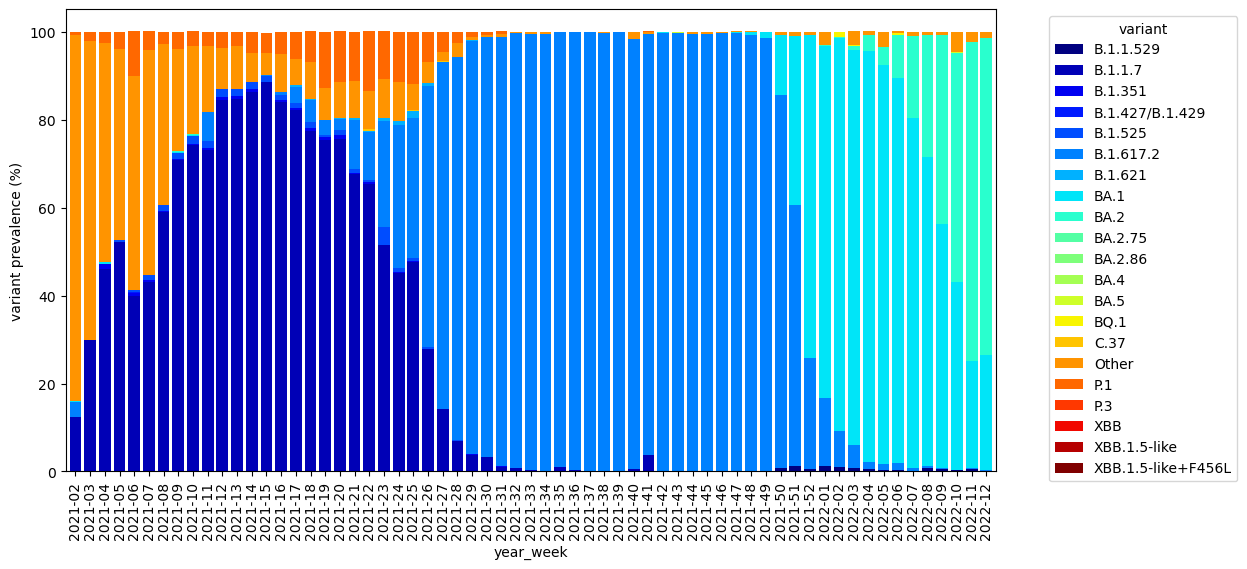

In [165]:
fig,ax = plt.subplots(figsize=(12, 6),)

dfp.plot.bar(stacked=True,  ylabel='variant prevalence (%)', width=.8, cmap=cm.jet, ax=ax)
plt.legend(title='variant', bbox_to_anchor=(1.05, 1), loc='upper left')

#in case the canvas does not appear
#plt.show()

notice that I created a legend outside the plot to avoid overlapping with the bars  
I used the `plt.legend` command, which collects colors and handles of the plot  
caution, the correct way to do this is: 
* creating the canvas with `plt.subplots`
* use the command `ax=ax` within the `dataframe.plot.bar` command, telling pandas to use the canvas i created with `plt.subplots`
* use `plt.legend` to draw the legend

if we don't use the command `ax=ax`, pandas will plot in another canvas and matplotlib will not know what legend we want to plot

### What model do we need to describe the variants takeover?

We use a logistic growth model to reproduce the variant growth in prevalence (%)   
with variants competition encoded by the growth rates difference in exponential growth
$$ \Large p(t) = 1 / (1 + \frac{1 - p_0}{p_0} e^{(r_v-r_h) t})  $$

This relationship results from assuming that there are two concurrent exponential growths in the population, namely of dominant and invading variant. This formula explicits the fraction at time t of cases belonging to the new variant over the sum of both variants' cases.
It can be rewritten as $$ \Large p(t) = p_0 e^{r_v t} / (p_0 e^{r_v t} + (1 - p_0) e^{r_h t} ) $$

#### fitting
We use a Binomial likelihood to fit the fraction p(t) of total cases N(t) belonging to the new variant D(t) at time t
$$ \Large \textit{L} = \prod_t Binom(D(t); N(t), p(t)) $$

### Pipeline test: Simulated scenario

<div class="alert alert-info" style="font-size:120%">

**Conditions of the Experiment**
We create a synthetic scenario setting all parameters by hand, then pretend we don't know part of it and estimate them back 

We set
* Rh and Rv
* generation time
* growth rates rh and rv 
* p0 =>  the entire logistic growth curve
=> casP is extracted from casN (the total sequenced cases at time t) with probability p(t)   

In real scenarios, we don't have p0, nor Rv! Hence no p(t) nor casP!

**We know - data input**
* Rh
* generation time
* rh
* casN (the total sequenced cases at time t)

**Pretend we don't know - target variables**

* Rv
* rv, 
* p0, 
=> the logistic growth curve
=> casP is extracted from casN

**Procedure**

* set priot probabilities to p0 and rv
* fit p0 and rv as free parameters usign a monte carlo markov chain method maximising the binomial likelihood
* compute advantage $\alpha$


**Validation**
* compare Rv fitted with the synthetic Rv
* compare the fitted with the synthetic p(t) curve

</div>

In [89]:

# Constants
T = 20 #n of weeks
Tf = 8 #n of weeks with data
M = 1 #n of regions in which you have data

# Set generation time of dominant variant, assume GT is equal for both variants
gt_mn = 4.8  # in days
gt_std = 1.2
cv = gt_std/gt_mn
a = (1/cv)**2 #shape
b = a / gt_mn #rate

# True values for simulation
Rh_true = 1.38 
Rv_true = 2.1 

rh_true = (Rh_true**(1/a) - 1) * b 
rv_true = (Rv_true**(1/a) - 1) * b 


# Data on first weeks prevalence of invading variant
p0_true = np.random.uniform(0, 0.01, size=M)

# Time matrix
time = np.arange(1, T + 1)
t_matrix = np.tile(time, (M, 1))  # shape (M, T)

# Simulate the variant growth in prevalence with the logistic growth function
logit_init = ((1 - p0_true) / p0_true)[:, np.newaxis]
growth_diff = (rh_true - rv_true) * t_matrix * 7
p_true = 1 / (1 + logit_init * np.exp(growth_diff))  # shape (M, T)

# Simulate observed data, number of sequenced tests "casN" and positive to new variants "casP"
casN = np.random.randint(400, 1000, size=(M, Tf))
casP = np.random.binomial(n=casN, p=p_true[:, :Tf])

Text(0.5, 0, 'weeks')

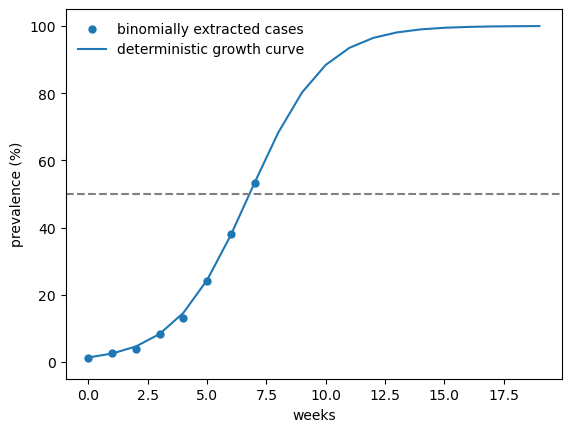

In [102]:
prev = {}
for m in range(M):
    #plot data
    plt.scatter(np.arange(Tf),casP[m]/casN[m]*100,marker='o', lw=0, label='binomially extracted cases')

plt.plot(p_true[0]*100, label='deterministic growth curve');
plt.legend(frameon=False)
plt.axhline(50, ls='--', color='grey')
plt.ylim(-5,105)
plt.ylabel('prevalence (%)')
plt.xlabel('weeks')

### Gaymard et al

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Rv, p0]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 1 seconds.


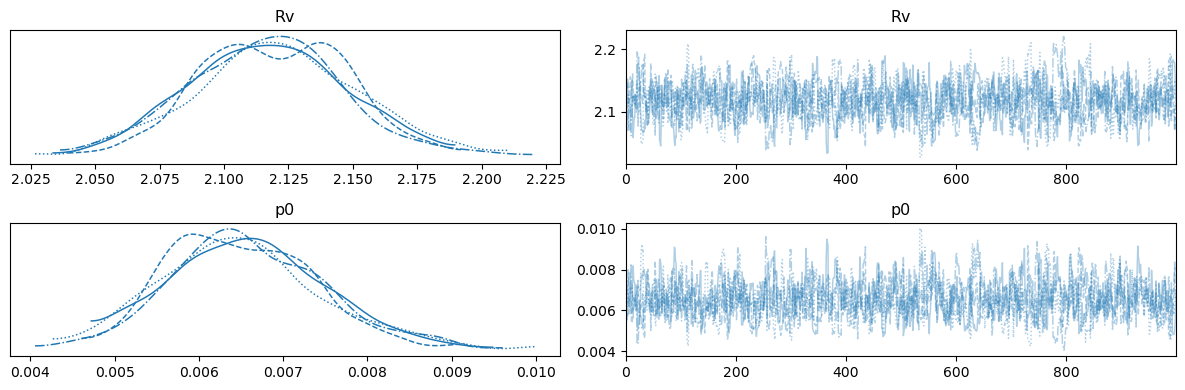

       mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Rv     2.12  0.03    2.06     2.18        0.0      0.0    681.73    894.87   
p0[0]  0.01  0.00    0.00     0.01        0.0      0.0    692.05    894.70   

       r_hat  
Rv       1.0  
p0[0]    1.0  


In [91]:

# --------------------------
# PyMC Model (v5.23.0)
# --------------------------

with pm.Model() as model:

    # Global reproduction numbers with Gamma priors
    Rv = pm.Gamma("Rv", alpha=2, beta=1)  # R0 for Omicron

    # Convert to growth rates
    rv = pm.Deterministic("rv", ( Rv**(1/a) - 1) * b )

    # Initial Omicron proportions (p0), inferred per region
    p0 = pm.Exponential("p0", lam=3, shape=M)

    # Time matrix
    t_vals = np.arange(1, T + 1)
    t_matrix = np.tile(t_vals, (M, 1))  # shape (M, T)

    # Logistic growth computation
    logit_init = ((1 - p0) / p0).dimshuffle(0, 'x')  # shape (M, 1)
    growth_diff = (rh_true - rv) * t_matrix * 7
    p = pm.Deterministic("p", 1 / (1 + logit_init * np.exp(growth_diff)))

    # Likelihood
    casP_obs = pm.Binomial("casP_obs", n=casN, p=p[:, :Tf], observed=casP)

    # Sampling
    trace = pm.sample(draws=1000, tune=500, discard_tuned_samples=True, chains=4, target_accept=0.95, random_seed=42)

# --------------------------
# Results
# --------------------------

az.plot_trace(trace, var_names=["Rv", "p0"])
plt.tight_layout()
plt.show()

print(az.summary(trace, var_names=["Rv", "p0"], round_to=2))


In [92]:
p0=dict()
for m in range(M):
    p0[m]=np.median(np.ravel(trace.posterior.p0.T[m]))

Rv=np.median(np.ravel(trace.posterior.Rv));
Rv_up=np.percentile(np.ravel(trace.posterior.Rv),95);
Rv_dw=np.percentile(np.ravel(trace.posterior.Rv),5)

rv = (Rv**(1/a) - 1) * b; 
rv_up = (Rv_up**(1/a) - 1) * b; 
rv_dw = (Rv_dw**(1/a) - 1) * b 

print("Rv = "+str(round(Rv,2))+" 95%CrI "+str(round(Rv_dw,2)),"-",str(round(Rv_up,2)) )

print('\N{greek small letter alpha}', str(100*round(Rv/Rh_true - 1,2))+"%")

Rv = 2.12 95%CrI 2.07 - 2.17
α 53.0%


[0.01230332 0.02321696 0.04338626 0.07964854 0.14172851 0.23959844
 0.37548485 0.53428794 0.68643227 0.80684164 0.88852296 0.93830468
 0.96668908 0.98226143 0.99062455 0.99506456 0.99740738 0.9986396
 0.99928659 0.99962599]


Text(0.5, 0, 'weeks')

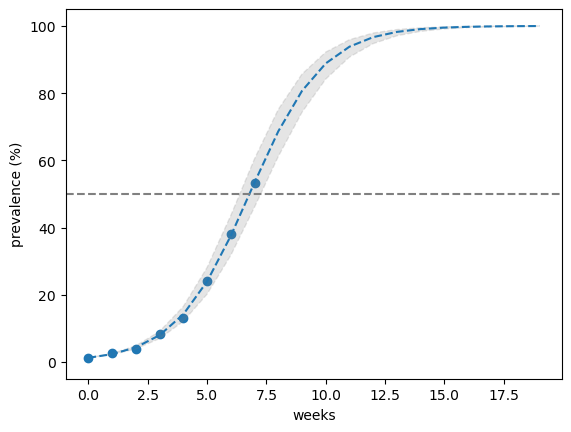

In [97]:
prev = {};prev_up = {};prev_dw = {}
for m in range(M):
    logit_init = ((1 - p0[m]) / p0[m])  # shape (M, 1)
    growth_diff = (rh_true - rv) * t_matrix[0] * 7; 
    growth_diff_up = (rh_true - rv_up) * t_matrix[0] * 7; 
    growth_diff_dw = (rh_true - rv_dw) * t_matrix[0] * 7
    prev[m] = 1 / (1 + logit_init * np.exp(growth_diff)); 
    prev_up[m] = 1 / (1 + logit_init * np.exp(growth_diff_up)); 
    prev_dw[m] = 1 / (1 + logit_init * np.exp(growth_diff_dw))
    print(prev[m])
    #plot data
    plt.scatter(np.arange(Tf),casP[m]/casN[m]*100)

    #plot model
    plt.plot(range(T),prev[m]*100, ls='--')
    plt.fill_between(range(T),prev_up[m]*100, prev_dw[m]*100,ls='--', color='grey', alpha=.2)

    
    
plt.axhline(50, ls='--', color='grey')
plt.ylim(-5,105)
plt.ylabel('prevalence (%)')
plt.xlabel('weeks')

<div class="alert alert-info" style="font-size:120%">

**Simulated scenario wrap-up:**


stochasticity here lies in two random variables here: p0 and the casP extracted binomially  
* the p0 defines the initial fraction of cases assigned to the invading variant. this informs the logistic growth curve, p(t)  
* casP is extracted from casN (the total sequenced cases at time t) with probability p(t)   

we will fit p0 as a free parameter

In real scenarios, we don't have p0, nor p(t)!
</div>

### Now with real data, one country  
go to https://www.ecdc.europa.eu/en/publications-data/data-virus-variants-covid-19-eueea    
and download the data

<div class="alert alert-info" style="font-size:120%">

**Conditions of the Experiment**

Now for real... 

**We know - data input**
* Rh
* generation time
* rh
* casN (the total sequenced cases at time t)

**We don't know - target variables**

* Rv
* rv, 
* p0, 
=> the logistic growth curve
=> casP is extracted from casN

**Procedure**

* set priot probabilities to p0 and rv
* fit p0 and rv as free parameters usign a monte carlo markov chain method maximising the binomial likelihood
* compute advantage $\alpha$


**Validation**
* check overlap of fitted curve p(t) with data points

</div>

In [118]:
data = pd.read_csv('../covid_gisaid.csv')
data = data.dropna()
data = data[(data.year_week>'2021-01')&(data.year_week<='2022-12')]
data = data[data.variant!='UNK']
data = data[(data.country == 'Italy') & (data.source=='GISAID')]

In [119]:

data = data[['country','year_week','variant', 'number_sequenced', 'number_detections_variant', 'percent_variant']]


In [120]:

# use groupby on df
dataf = data.groupby(['year_week', 'variant'])['percent_variant'].sum().reset_index()
# pivot the dataframe into the correct format
dfp = dataf.pivot(index='year_week', columns='variant', values='percent_variant')
dfp.head()

variant,B.1.1.529,B.1.1.7,B.1.351,B.1.427/B.1.429,B.1.525,B.1.617.2,B.1.621,BA.1,BA.2,BA.2.75,...,BA.4,BA.5,BQ.1,C.37,Other,P.1,P.3,XBB,XBB.1.5-like,XBB.1.5-like+F456L
year_week,,,,,,,,,,,,,,,,,,,,,
2021-02,0.0,12.4,0.0,0.1,0.0,3.4,0.0,0.1,0.0,0.0,...,0.0,0.0,0.0,0.0,83.2,0.7,0.0,0.0,0.0,0.0
2021-03,0.0,29.8,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,68.1,1.9,0.0,0.0,0.0,0.0
2021-04,0.0,46.0,1.3,0.0,0.0,0.0,0.0,0.4,0.0,0.0,...,0.0,0.0,0.0,0.0,49.8,2.5,0.0,0.0,0.0,0.0
2021-05,0.0,52.1,0.1,0.0,0.4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,43.4,4.0,0.0,0.0,0.0,0.0
2021-06,0.0,40.0,0.7,0.1,0.4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,48.8,10.1,0.0,0.0,0.0,0.0


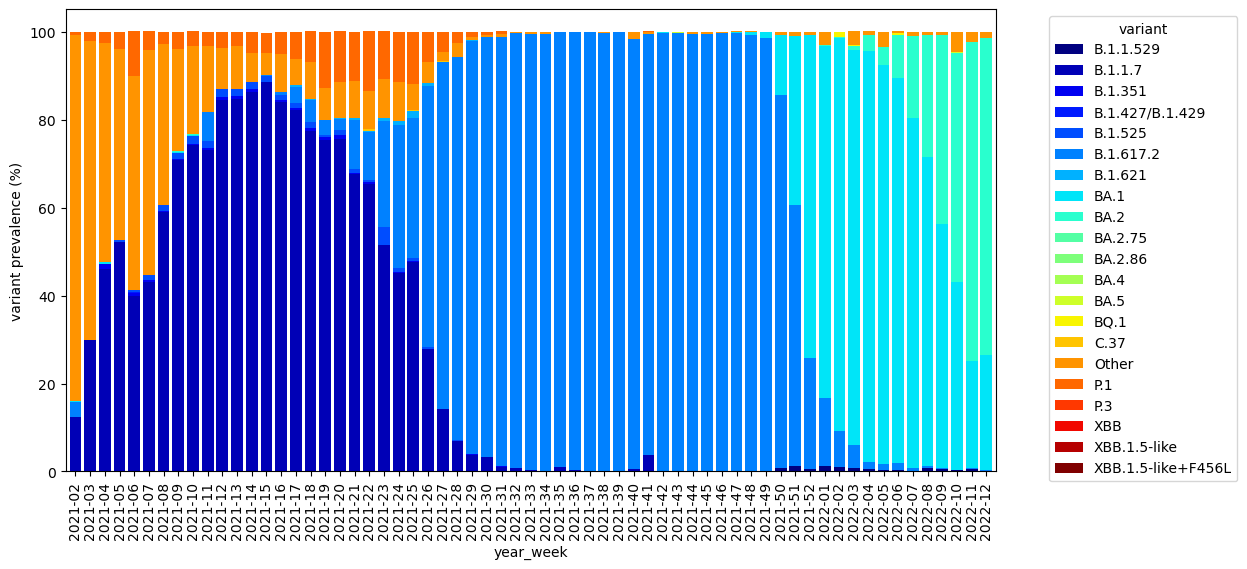

In [121]:

fig,ax = plt.subplots(figsize=(12, 6),)

# plot the pivoted dataframe
dfp.plot.bar(stacked=True,  ylabel='variant prevalence (%)', width=.8, cmap=cm.jet, ax=ax)
plt.legend(title='variant', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

### set the data

In [143]:

data_start_week = '2021-44'
data_end_week = '2021-49'
data_mod = data[(data.year_week>data_start_week)&(data.year_week<=data_end_week)]
delta = data_mod[data_mod.variant == 'B.1.617.2'][['country','year_week', 'number_sequenced', 'number_detections_variant', 'percent_variant']]
omicron = data_mod[data_mod.variant == 'BA.1'][['country','year_week', 'number_sequenced', 'number_detections_variant','percent_variant']]

Text(0.5, 0, 'weeks')

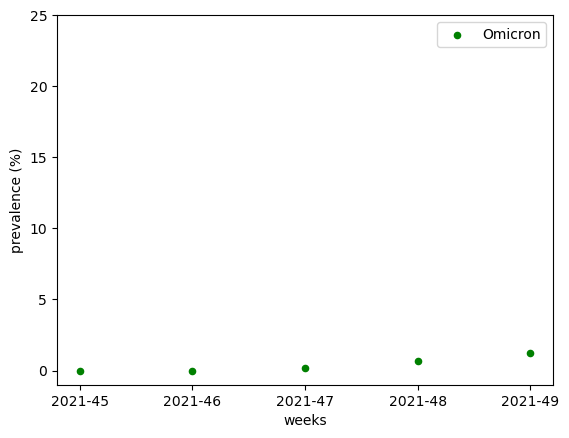

In [144]:
fig,ax=plt.subplots()
omicron.plot.scatter(x='year_week',y='percent_variant',label='Omicron', color='g', ax=ax)

plt.axhline(50, ls='--', color='grey')
plt.ylim(-1,25)
plt.ylabel('prevalence (%)')
plt.xlabel('weeks')

Delta generation time parameters from https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(22)00001-9/fulltext  
Delta reproduction number https://dl.acm.org/doi/abs/10.1145/3498731.3498754 and https://link.springer.com/article/10.1186/s12985-023-02018-x

In [145]:

# Constants
T = 15 #n of weeks overall
Tf = len(data_mod.year_week.unique()) #n of weeks with data
M = 1 #n of regions in which you have data

# Set generation time of dominant variant, assume GT is equal for both variants
gt_mn = 4.7  # mean in days
gt_std = 3.3 # standard deviation
cv = gt_std/gt_mn #coef of variation
a = (1/cv)**2
b = a / gt_mn

# Simulate observed data, number of sequenced tests "casN" and positive to new variants "casP"
casN = omicron.number_sequenced.values.reshape(M, Tf)
casP = omicron.number_detections_variant.values.reshape(M, Tf)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 4 jobs)
NUTS: [Rv, p0]


Output()

Sampling 6 chains for 1_000 tune and 500 draw iterations (6_000 + 3_000 draws total) took 2 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


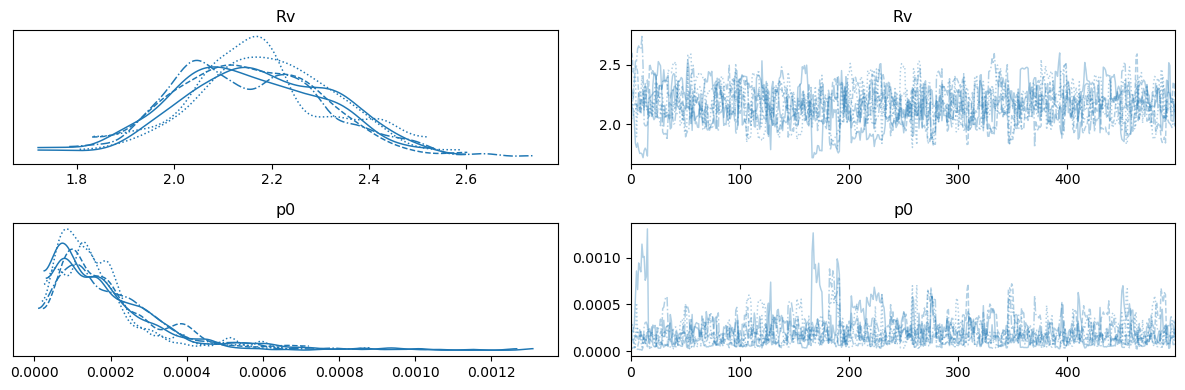

       mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Rv     2.16  0.15    1.87     2.45       0.01      0.0    502.00    563.53   
p0[0]  0.00  0.00    0.00     0.00       0.00      0.0    490.35    542.50   

       r_hat  
Rv      1.02  
p0[0]   1.02  


In [146]:

Rh = 1.38  # R0 for Delta
rh = (Rh**(1/a) - 1) * b 

with pm.Model() as model:

    # Global reproduction numbers with Gamma priors
    Rv = pm.Gamma("Rv", alpha=2, beta=1)  # R0 for Omicron

    # Convert to growth rates
    rv = pm.Deterministic("rv", ( Rv**(1/a) - 1) * b ) #growth rate for Omicron

    # Initial Omicron proportions (p0), inferred per region
    p0 = pm.Exponential("p0", lam=2, shape=M)

    # Time matrix
    t_vals = np.arange(1, T + 1)
    t_matrix = np.tile(t_vals, (M, 1))  # shape (M, T)

    # Logistic growth computation
    logit_init = ((1 - p0) / p0).dimshuffle(0, 'x')  # shape (M, 1)
    growth_diff = (rh - rv) * t_matrix * 7
    p = pm.Deterministic("p", 1 / (1 + logit_init * np.exp(growth_diff)))

    # Likelihood
    casP_obs = pm.Binomial("casP_obs", n=casN, p=p[0, :Tf], observed=casP)

    # Sampling
    trace = pm.sample(draws=500, tune=1000, chains=6, target_accept=0.95, random_seed=42)

# --------------------------
# Results
# --------------------------

az.plot_trace(trace, var_names=["Rv", "p0"])
plt.tight_layout()
plt.show()

print(az.summary(trace, var_names=["Rv", "p0"], round_to=2))


In [147]:
p0=dict()
for m in range(M):
    p0[m]=np.median(np.ravel(trace.posterior.p0.T[m]))

Rv=np.median(np.ravel(trace.posterior.Rv));Rv_up=np.percentile(np.ravel(trace.posterior.Rv),95);Rv_dw=np.percentile(np.ravel(trace.posterior.Rv),5)

rv = (Rv**(1/a) - 1) * b; rv_up = (Rv_up**(1/a) - 1) * b; rv_dw = (Rv_dw**(1/a) - 1) * b 

print("Rv = "+str(round(Rv,2))+" 95%CrI "+str(round(Rv_dw,2)),"-",str(round(Rv_up,2)) )

print('\N{greek small letter alpha}', str(100*round(Rv/Rh - 1,2))+"%")

Rv = 2.16 95%CrI 1.92 - 2.42
α 56.00000000000001%


[3.73725043e-04 8.95454461e-04 2.14396893e-03 5.12433415e-03
 1.21971105e-02 2.87498637e-02 6.62596100e-02 1.45382618e-01
 2.89677311e-01 4.94345568e-01 7.00926650e-01 8.48906149e-01
 9.30886067e-01 9.69959668e-01 9.87245653e-01]


Text(0.5, 0, 'weeks')

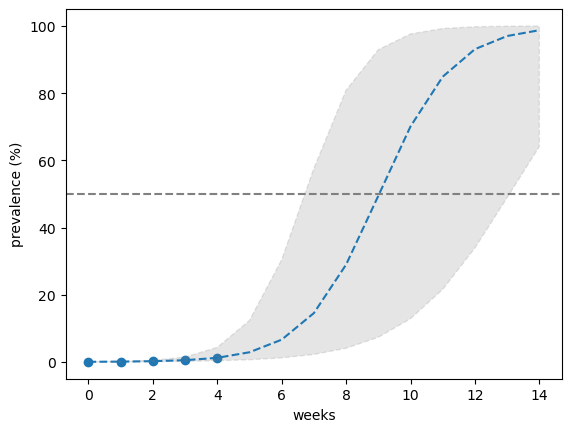

In [148]:

prev = {}
for m in range(M):
    logit_init = ((1 - p0[m]) / p0[m])  # shape (M, 1)
    growth_diff = (rh - rv) * t_matrix[0] * 7
    prev[m] = 1 / (1 + logit_init * np.exp(growth_diff))
    growth_diff = (rh - rv) * t_matrix[0] * 7; 
    growth_diff_up = (rh - rv_up) * t_matrix[0] * 7; 
    growth_diff_dw = (rh - rv_dw) * t_matrix[0] * 7
    prev[m] = 1 / (1 + logit_init * np.exp(growth_diff)); 
    prev_up[m] = 1 / (1 + logit_init * np.exp(growth_diff_up)); 
    prev_dw[m] = 1 / (1 + logit_init * np.exp(growth_diff_dw))
    print(prev[m])
    #plot data
    plt.scatter(np.arange(Tf),casP[m]/casN[m]*100)

    #plot model
    plt.plot(range(T),prev[m]*100, ls='--')
    plt.fill_between(range(T),prev_up[m]*100, prev_dw[m]*100,ls='--', color='grey', alpha=.2)


plt.axhline(50, ls='--', color='grey')
plt.ylim(-5,105)
plt.ylabel('prevalence (%)')
plt.xlabel('weeks')


<div class="alert alert-success">

**EXERCISE 3: Check impact of number of data points on results accuracy**

* Repeat the estimate of the growth curve with more data points 

</div>

### now with multiple countries!

In [169]:

data = pd.read_csv('../data/covid_gisaid.csv')
#set countries
#countries = sorted(['Italy','France','Spain'])
countries = ['Austria','Belgium','Bulgaria','Croatia','Cyprus','Czechia','Denmark','Estonia','Finland','France','Germany',
             'Greece','Ireland','Italy','Latvia','Lithuania','Netherlands','Norway','Poland',
             'Portugal','Romania','Slovakia','Slovenia','Spain','Sweden']
lc = len(countries)

data = data.dropna()
data = data[(data.year_week>'2021-01')&(data.year_week<='2022-12')]
data = data[data.variant!='UNK']
data = data[(data.country.isin(countries) & (data.source=='GISAID'))]
data = data[['country','year_week','variant', 'number_sequenced', 'number_detections_variant', 'percent_variant']]

In [150]:
# use groupby on df
dataf = (data.groupby(['year_week', 'variant'])['percent_variant'].sum()/lc).reset_index()
# pivot the dataframe into the correct format
dfp = dataf.pivot(index='year_week', columns='variant', values='percent_variant')
dfp.head()

variant,B.1.1.529,B.1.1.7,B.1.351,B.1.427/B.1.429,B.1.525,B.1.617.2,B.1.621,BA.1,BA.2,BA.2.75,...,BA.4,BA.5,BQ.1,C.37,Other,P.1,P.3,XBB,XBB.1.5-like,XBB.1.5-like+F456L
year_week,,,,,,,,,,,,,,,,,,,,,
2021-02,0.0,22.060,1.524,0.008,0.040,0.324,0.0,0.064,0.004,0.0,...,0.0,0.0,0.0,0.000,75.944,0.028,0.000,0.0,0.0,0.0
2021-03,0.0,26.248,1.200,0.016,0.120,0.116,0.0,0.368,0.172,0.0,...,0.0,0.0,0.0,0.000,71.656,0.092,0.000,0.0,0.0,0.0
2021-04,0.0,31.508,0.748,0.020,0.116,0.256,0.0,0.104,0.000,0.0,...,0.0,0.0,0.0,0.000,67.104,0.148,0.000,0.0,0.0,0.0
2021-05,0.0,40.820,1.768,0.036,0.208,0.016,0.0,0.056,0.000,0.0,...,0.0,0.0,0.0,0.004,56.872,0.212,0.012,0.0,0.0,0.0
2021-06,0.0,43.716,2.148,0.016,0.224,3.332,0.0,0.024,0.016,0.0,...,0.0,0.0,0.0,0.000,49.924,0.584,0.000,0.0,0.0,0.0


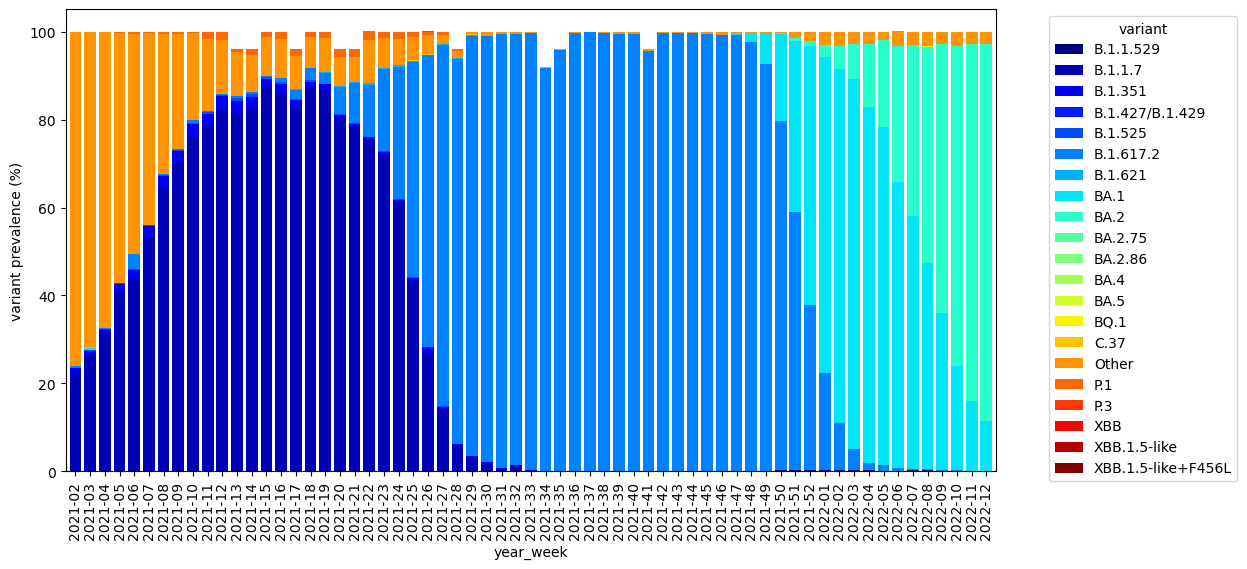

In [151]:
fig,ax = plt.subplots(figsize=(12, 6),)

# plot the pivoted dataframe
dfp.plot.bar(stacked=True,  ylabel='variant prevalence (%)', width=.8, cmap=cm.jet, ax=ax)
plt.legend(title='variant', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Text(0.5, 0, 'weeks')

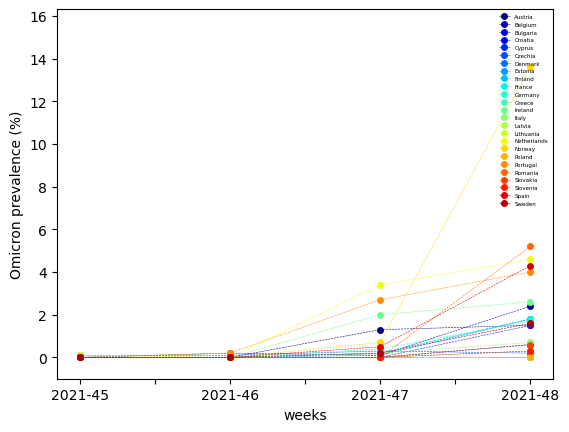

In [152]:
data_start_week = '2021-44'
data_end_week = '2021-48'
cmap = cm.jet
data_mod = data[(data.year_week>data_start_week)&(data.year_week<=data_end_week)]
all_weeks = sorted(data[data.year_week>data_start_week].year_week.unique())
delta = data_mod[data_mod.variant == 'B.1.617.2'][['country','year_week', 'number_sequenced', 'number_detections_variant', 'percent_variant']]
omicron = data_mod[data_mod.variant == 'BA.1'][['country','year_week', 'number_sequenced', 'number_detections_variant','percent_variant']]
fig,ax=plt.subplots()
#delta.plot.scatter(x='year_week',y='percent_variant',label='Delta', color='b', ax=ax)
for m,country in enumerate(countries):
    omicron[omicron.country==country].plot(x='year_week',y='percent_variant',marker='o', markersize=4, 
                                           lw=.4, ls='--', label=country, color=cmap(m/lc), ax=ax)
plt.legend(frameon=False, fontsize=4, loc='upper right')
plt.axhline(50, ls='--', color='grey')
plt.ylim(-1,max(omicron.percent_variant)*1.2)
plt.ylabel('Omicron prevalence (%)')
plt.xlabel('weeks')

/var/folders/q5/29y9rnzj2_3f5fwgkltpph4h0000gn/T/ipykernel_94515/2511531236.py:49: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(draws=1000, tune=1000, chains=6, start={'p0': np.full(M, 0.0001), "Rv" : 1.5}, target_accept=0.95, random_seed=42)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 4 jobs)
NUTS: [Rv, p0]


Output()

Sampling 6 chains for 1_000 tune and 1_000 draw iterations (6_000 + 6_000 draws total) took 6 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


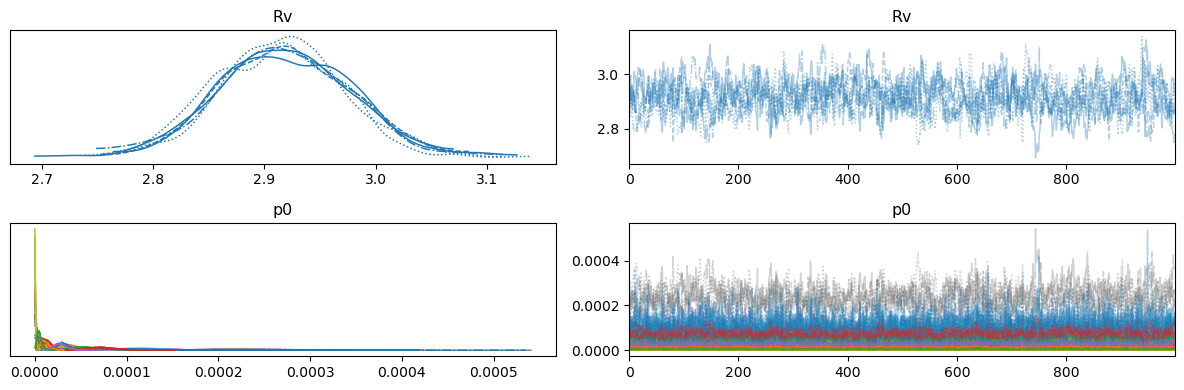

In [153]:

# Constants
T = 12 #n of weeks i want to model 
T_weeks = all_weeks[:T]
Tf = len(data_mod.year_week.unique()) #n of weeks with data
weeks = all_weeks[:Tf]
M = lc #n of regions in which you have data

# Set generation time of dominant variant, assume GT is equal for both variants
gt_mn = 4.7  # in days
gt_std = 3.3
cv = gt_std/gt_mn
a = (1/cv)**2
b = a / gt_mn

# Simulate observed data, number of sequenced tests "casN" and positive to new variants "casP"
casN = omicron.number_sequenced.values.reshape(M, Tf)
casP = omicron.number_detections_variant.values.reshape(M, Tf)
Rh = 1.38  # R0 for Delta
rh = (Rh**(1/a) - 1) * b 

# --------------------------
# PyMC Model (v5.23.0)
# ----------------------\----

with pm.Model() as model:

    # Global reproduction numbers with Gamma priors
    Rv = pm.Gamma("Rv", alpha=2, beta=1)  # R0 for Omicron

    # Convert to growth rates
    rv = pm.Deterministic("rv", ( Rv**(1/a) - 1) * b ) #growth rate for Omicron

    # Initial Omicron proportions (p0), inferred per region
    p0 = pm.Exponential("p0", lam=2, shape=M)

    # Time matrix
    t_vals = np.arange(1, T + 1)
    t_matrix = np.tile(t_vals, (M, 1))  # shape (M, T)

    # Logistic growth computation
    logit_init = ((1 - p0) / p0).dimshuffle(0, 'x')  # shape (M, 1)
    growth_diff = (rh - rv) * t_matrix * 7
    p = pm.Deterministic("p", 1 / (1 + logit_init * np.exp(growth_diff)))

    # Likelihood
    casP_obs = pm.Binomial("casP_obs", n=casN, p=p[:, :Tf], observed=casP)

    # Sampling
    trace = pm.sample(draws=1000, tune=1000, chains=6, start={'p0': np.full(M, 0.0001), "Rv" : 1.5}, target_accept=0.95, random_seed=42)

# --------------------------
# Results
# --------------------------

az.plot_trace(trace, var_names=["Rv", "p0"])
plt.tight_layout()
plt.show()


Rv = 2.92 95%CrI 2.82 - 3.01
α 111.00000000000001%


Text(0.5, 0, 'weeks')

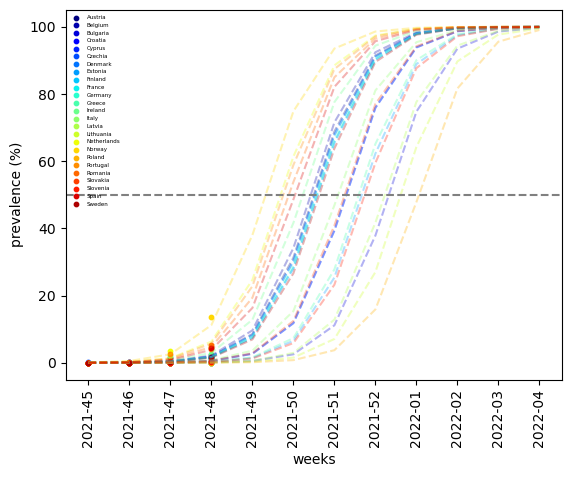

In [154]:

p0=dict()
for m in range(M):
    p0[m]=np.median(np.ravel(trace.posterior.p0.T[m]))
Rv=np.median(np.ravel(trace.posterior.Rv));Rv_up=np.percentile(np.ravel(trace.posterior.Rv),95);Rv_dw=np.percentile(np.ravel(trace.posterior.Rv),5)

rv = (Rv**(1/a) - 1) * b 

print("Rv = "+str(round(Rv,2))+" 95%CrI "+str(round(Rv_dw,2)),"-",str(round(Rv_up,2)) )

print('\N{greek small letter alpha}', str(100*round(Rv/Rh - 1,2))+"%")
prev = {}
prev_country = {}
for m, country in enumerate(countries):
    prev_country[country] = {}
    logit_init = ((1 - p0[m]) / p0[m])  # shape (M, 1)
    growth_diff = (rh - rv) * t_matrix[0] * 7
    prev[country] = 1 / (1 + logit_init * np.exp(growth_diff))
    #plot data
    plt.scatter(weeks,casP[m]/casN[m]*100, s=10, label=countries[m], color=cmap(m/lc))

    #plot model
    plt.plot(T_weeks,prev[country]*100, ls='--', color=cmap(m/lc), alpha=.3)
    for t,week in enumerate(T_weeks):
        prev_country[country][week] = prev[country][t]

plt.legend(frameon=False, fontsize=4)
plt.axhline(50, ls='--', color='grey')
plt.xticks(rotation=90)
plt.ylim(-5,105)
plt.ylabel('prevalence (%)')
plt.xlabel('weeks')

In [155]:
import geopandas as gpd  


maps shapefiles from https://ec.europa.eu/eurostat/web/gisco/geodata/administrative-units/countries

In [171]:
shpf = gpd.read_file('../data/CNTR_RG_60M_2024_3035.shp/CNTR_RG_60M_2024_3035.shp')

(1272524.0516100002, 5401681.8572)

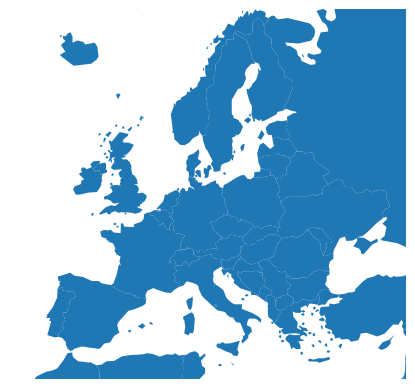

In [172]:
shpf.plot()
plt.axis('off')
plt.xlim(shpf[shpf.NAME_ENGL=='Iceland'].geometry.total_bounds[0]*0.8, shpf[shpf.NAME_ENGL=='Cyprus'].geometry.total_bounds[2]*1.02)
plt.ylim(shpf[shpf.NAME_ENGL=='Italy'].geometry.total_bounds[1]*0.9, shpf[shpf.NAME_ENGL=='Norway'].geometry.total_bounds[3]*1)


### Draw prevalence map

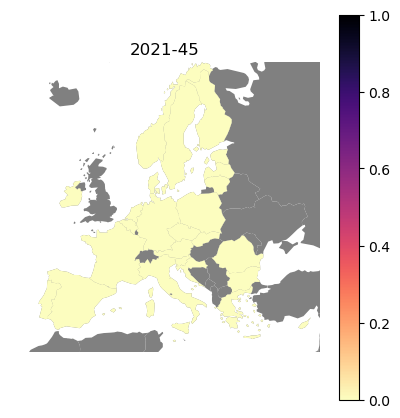

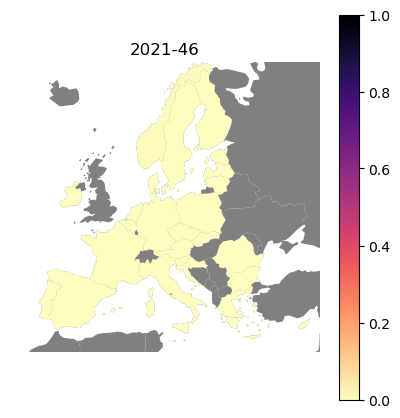

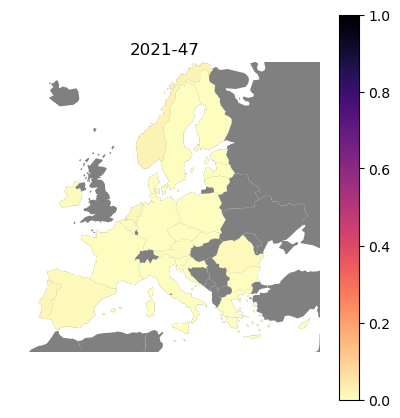

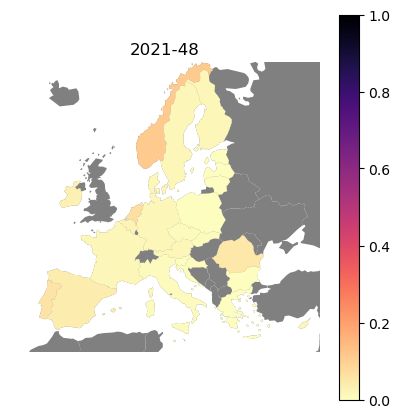

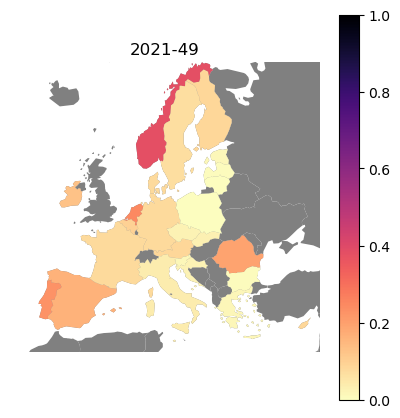

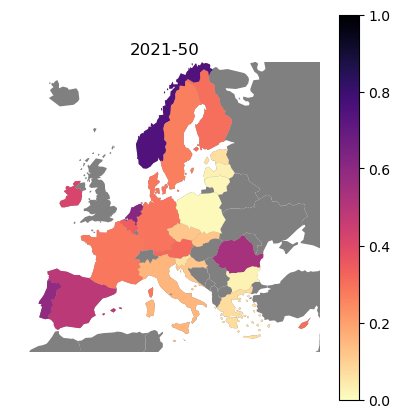

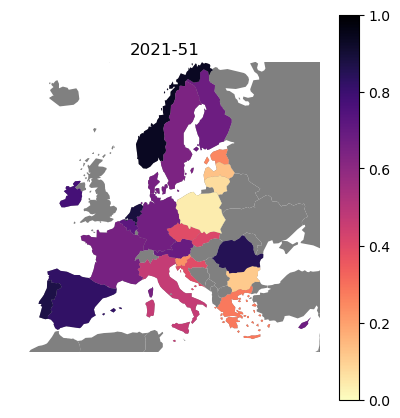

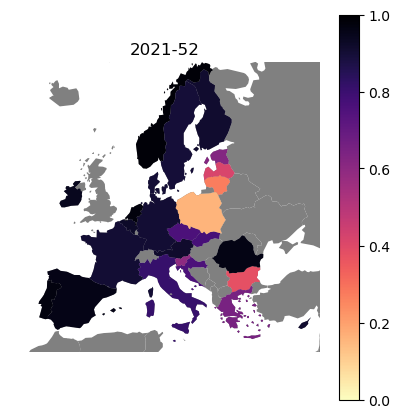

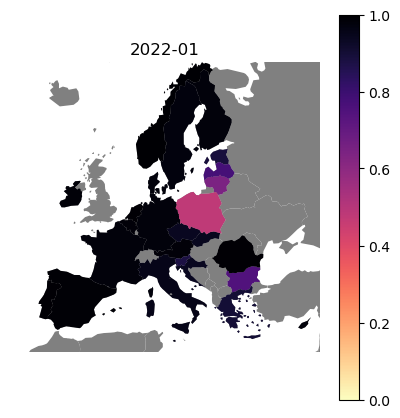

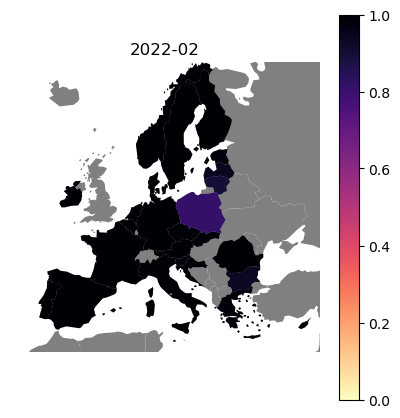

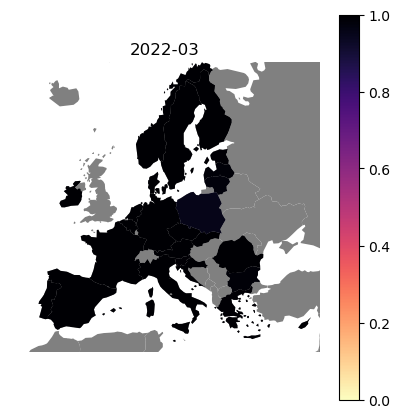

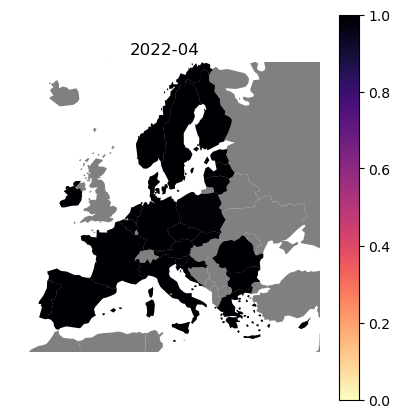

In [173]:
for i in range(len(T_weeks)):
    set_week = T_weeks[i]
    shpf_eu = shpf[shpf.NAME_ENGL.isin(countries)]
    shpf_eu = shpf_eu[['NAME_ENGL','geometry']]
    shpf_eu['prev'] = shpf_eu['NAME_ENGL'].apply(lambda x: prev_country[x][set_week])
    fig,ax=plt.subplots(figsize=(5,5))
    ax.set_title(set_week)
    shpf.plot(color='grey',ax=ax)
    shpf_eu.plot(column='prev',cmap=cm.magma_r, legend=True, vmin=0, vmax=1,ax=ax)
    ax.axis('off')
    ax.set_xlim(shpf[shpf.NAME_ENGL=='Iceland'].geometry.total_bounds[0]*0.8, shpf[shpf.NAME_ENGL=='Cyprus'].geometry.total_bounds[2]*1.02)
    ax.set_ylim(shpf[shpf.NAME_ENGL=='Italy'].geometry.total_bounds[1]*0.9, shpf[shpf.NAME_ENGL=='Norway'].geometry.total_bounds[3]*1)